## Create ML-ready dataset for a Regional Grain Size Model

* Dan Buscombe 
* Will Speiser

3/24/22 - May 2022

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import folium
import io
from PIL import Image
import os, time
# from selenium import webdriver
# import geocoder
from tqdm import tqdm
import geopandas as gpd
# import pygeos

#### data processing choices

This number has to factor in very large errors in some g-s position data

In [2]:
# join_dist=.0005
# join_dist=.001
join_dist=.0015
# join_dist=.003

In [3]:
# choice = 'beach'
choice = 'transects'

In [4]:
merge = 'right'
# merge = 'left'

#### read gs data 

In [5]:
dataset = 'Data_Post2012_VerifiedOnshore'
#dataset = 'Data_VerifiedOnshore'

In [6]:
dataset2 = 'sed_data_wrangle_final'

In [7]:
path='./data/CGRASP' 

In [8]:
cgrasp_dat = pd.read_csv(path+'/'+dataset+'.csv')
sand = cgrasp_dat[cgrasp_dat['d50']<2]

In [9]:
# len(sand)

In [10]:
cgrasp_dat2 = pd.read_csv(path+'/'+dataset2+'.csv')
sand2 = cgrasp_dat2[cgrasp_dat2['d50']<2]

In [11]:
# len(sand2)

In [12]:
merged_sand = pd.concat([sand, sand2])

In [13]:
# gdf_sand = gpd.GeoDataFrame(
#     sand, geometry=gpd.points_from_xy(sand.longitude, sand.latitude))

gdf_merged_sand = gpd.GeoDataFrame(
    merged_sand, geometry=gpd.points_from_xy(merged_sand.longitude, merged_sand.latitude))

In [14]:
# len(gdf_sand)
len(gdf_merged_sand)

1759

#### read slope data 

In [15]:
slopes_t = pd.DataFrame(gpd.read_file('./data/beach_slopes/US_East_coast_slopes_by_transect.geojson'))
slopes_b = pd.DataFrame(gpd.read_file('./data/beach_slopes/US_East_coast_slopes_by_beach.geojson'))

In [16]:
len(slopes_t)

34067

In [17]:
slopes_t['points'] = slopes_t.apply(lambda x: [y for y in x['geometry'].coords], axis=1)
latlon = np.vstack([np.mean(s,axis=0) for s in slopes_t.points.values])

slopes_t.insert(2, "longitude", latlon[:,0], True)
slopes_t.insert(3, "latitude", latlon[:,1], True)

In [18]:
slopes_b['points'] = slopes_b.apply(lambda x: [y for y in x['geometry'].coords], axis=1)
latlon = np.vstack([np.mean(s,axis=0) for s in slopes_b.points.values])

slopes_b.insert(2, "longitude", latlon[:,0], True)
slopes_b.insert(3, "latitude", latlon[:,1], True)

In [19]:
slopes_b.keys()

Index(['id', 'beach_slope_weighted_average', 'longitude', 'latitude',
       'width_ci_average', 'quality_flag', 'beach_slope_average',
       'beach_slope_median', 'sl_points_average', 'mstr', 'prc_mstr_obs',
       'min_tide_obs', 'max_tide_obs', 'easting', 'northing', 'geometry',
       'points'],
      dtype='object')

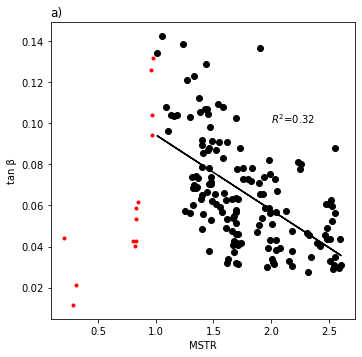

In [20]:
X = np.vstack((slopes_b['mstr'],slopes_b['beach_slope_average']))

X = X[:,~np.isnan(X).any(axis=0)]

plt.figure(figsize=(12,12))
plt.subplot(221)
plt.plot(X[0,:],X[1,:], 'r.')

ind = np.where(X[0,:]>=1)[0]
X = X[:,ind]

X.shape
plt.plot(X[0,:],X[1,:], 'ko')

plt.ylabel(r'tan β')
plt.xlabel(r'MSTR')
plt.title(r"a)", loc='left')
r2 = np.min(np.corrcoef(X[0,:],X[1,:]))**2
plt.text(2,.1,r'$R^2$='+str(r2)[:4])

coef = np.polyfit(X[0,:],X[1,:],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(X[0,:], poly1d_fn(X[0,:]), '-k')

plt.savefig('data_plots/Partial_correl_a.jpg', dpi=300, bbox_inches='tight')

#### plot grain size and slope data on map

In [21]:
# map = folium.Map(
#                 location=[np.mean(sand['latitude']), np.mean(sand['longitude'])], 
#                 zoom_start=4, 
#                 control_scale=True,
#                 tiles='stamentoner',#tiles="Stamen Terrain", 
# )

In [22]:
# for counter, (lat,lon) in enumerate(zip(sand['latitude'],sand['longitude'])):
#     folium.CircleMarker(location=[lat, lon],
#                                 radius = 3,
#                                 fill=True, # Set fill to True
#                                 color = 'red',
#                                 opacity=0.1,
#                                 fill_opacity=0.7).add_to(map)

In [23]:
# for counter, (lat,lon) in enumerate(zip(slopes_t['latitude'],slopes_t['longitude'])):
#     folium.CircleMarker(location=[lat, lon],
#                                 radius = 3,
#                                 fill=True, # Set fill to True
#                                 color = 'blue',
#                                 opacity=0.1,
#                                 fill_opacity=0.7).add_to(map)

In [24]:
# for counter, (lat,lon) in enumerate(zip(slopes_b['latitude'],slopes_b['longitude'])):
#     folium.CircleMarker(location=[lat, lon],
#                                 radius = 3,
#                                 fill=True, # Set fill to True
#                                 color = 'magenta',
#                                 opacity=0.1,
#                                 fill_opacity=0.7).add_to(map)

In [25]:
# map

In [26]:
choice

'transects'

In [27]:
merge

'right'

In [28]:
# if choice=='beach':
#     slopes = slopes_b.copy()
# else:
#     slopes = slopes_t.copy()

In [29]:
if choice=='transects':
    gdf_slopes_b = gpd.GeoDataFrame(
    slopes_b, geometry=gpd.points_from_xy(slopes_b.longitude, slopes_b.latitude))

    gdf_slopes_t = gpd.GeoDataFrame(
    slopes_t, geometry=gpd.points_from_xy(slopes_t.longitude, slopes_t.latitude))    
    
    gdf_slopes = gpd.sjoin_nearest(gdf_slopes_b, gdf_slopes_t, how=merge, distance_col='distance')
    
else:
    gdf_slopes = gpd.GeoDataFrame(
    slopes_b, geometry=gpd.points_from_xy(slopes_b.longitude, slopes_b.latitude))  
    
len(gdf_slopes)  

34067

In [30]:
gdf_slopes = gdf_slopes[['beach_slope_weighted_average',
       'longitude_left', 'latitude_left', 'width_ci_average',
       'quality_flag_left', 'beach_slope_average', 'beach_slope_median',
       'sl_points_average', 'mstr', 'prc_mstr_obs', 'min_tide_obs',
       'max_tide_obs','site_id', 'longitude_right', 'latitude_right', 'beach_slope',
       'lower_conf_bound', 'upper_conf_bound', 'width_ci','geometry',
       'quality_flag_right', 'sl_points', 'trend',
       'distance']].copy()

gdf_slopes.keys()

gdf_slopes = gpd.GeoDataFrame(gdf_slopes)

type(gdf_slopes)

geopandas.geodataframe.GeoDataFrame

In [31]:
# gs_w_slope_data=gpd.sjoin_nearest(gdf_sand, gdf_slopes, how=merge)#, distance_col='distance')
gs_w_slope_data=gpd.sjoin_nearest(gdf_merged_sand, gdf_slopes, how=merge)

len(gs_w_slope_data)

39776

In [32]:
ind = np.where(gs_w_slope_data['distance']<join_dist)[0]
tmp = gs_w_slope_data.iloc[ind]
len(tmp)

431

In [33]:
tmp = tmp[['latitude', 'longitude', 'd50', 'geometry', 
       'longitude_left', 'latitude_left', 'quality_flag_right','quality_flag_left',
        'beach_slope_average','sl_points', 'trend', 'width_ci_average',
       'beach_slope_median', 'sl_points_average', 'mstr', 'prc_mstr_obs',
       'min_tide_obs', 'max_tide_obs', 'site_id', 'longitude_right',
       'latitude_right', 'beach_slope', 'lower_conf_bound', 'upper_conf_bound',
       'width_ci', 'distance']].copy() 

#''d25', 'd30','d65', 'd75',

In [34]:
len(tmp.dropna())

402

In [35]:
tmp = tmp.dropna()

In [36]:
tmp.keys()

Index(['latitude', 'longitude', 'd50', 'geometry', 'longitude_left',
       'latitude_left', 'quality_flag_right', 'quality_flag_left',
       'beach_slope_average', 'sl_points', 'trend', 'width_ci_average',
       'beach_slope_median', 'sl_points_average', 'mstr', 'prc_mstr_obs',
       'min_tide_obs', 'max_tide_obs', 'site_id', 'longitude_right',
       'latitude_right', 'beach_slope', 'lower_conf_bound', 'upper_conf_bound',
       'width_ci', 'distance'],
      dtype='object')

In [38]:
# try:
#     map = folium.Map(
#                     location=[np.mean(tmp['latitude_right']), np.mean(tmp['longitude_right'])], 
#                     zoom_start=4, 
#                     control_scale=True,
#                     tiles='stamentoner',#tiles="Stamen Terrain", 
#     )
    
#     for counter, (lat,lon) in enumerate(zip(tmp['latitude_right'],tmp['longitude_right'])):
#         folium.CircleMarker(location=[lat, lon],
#                                     radius = 3,
#                                     fill=True, # Set fill to True
#                                     color = 'magenta',
#                                     opacity=0.1,
#                                     fill_opacity=0.7).add_to(map)

# except:
#     map = folium.Map(
#                     location=[np.mean(tmp['latitude_left']), np.mean(tmp['longitude_left'])], 
#                     zoom_start=4, 
#                     control_scale=True,
#                     tiles='stamentoner',#tiles="Stamen Terrain", 
#     )
    
#     for counter, (lat,lon) in enumerate(zip(tmp['latitude_left'],tmp['longitude_left'])):
#         folium.CircleMarker(location=[lat, lon],
#                                     radius = 3,
#                                     fill=True, # Set fill to True
#                                     color = 'magenta',
#                                     opacity=0.1,
#                                     fill_opacity=0.7).add_to(map)
    
# map

Text(0.25, 0.16, '$R^2$=0.27')

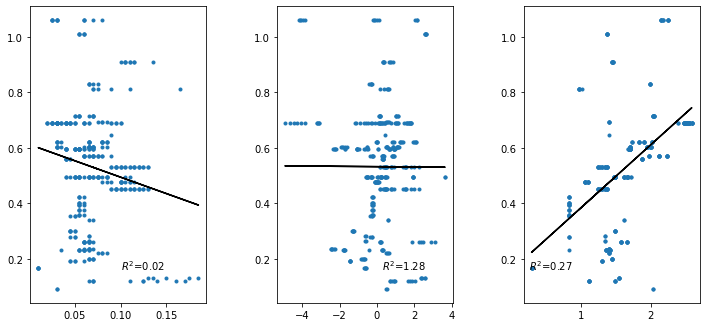

In [39]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.4)
plt.subplot(231)
plt.plot(tmp['beach_slope'],tmp['d50'],'.')

coef = np.polyfit(tmp['beach_slope'],tmp['d50'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['beach_slope'], poly1d_fn(tmp['beach_slope']), '-k')

r2 = np.min(np.corrcoef(tmp['d50'], tmp['beach_slope']))**2
plt.text(.1,.16,r'$R^2$='+str(r2)[:4])

plt.subplot(232)
plt.plot(tmp['trend'],tmp['d50'],'.')

coef = np.polyfit(tmp['trend'],tmp['d50'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['trend'], poly1d_fn(tmp['trend']), '-k')

r2 = np.min(np.corrcoef(tmp['d50'], tmp['trend']))**2
plt.text(.25,.16,r'$R^2$='+str(r2)[:4])

plt.subplot(233)
plt.plot(tmp['mstr'],tmp['d50'],'.')

coef = np.polyfit(tmp['mstr'],tmp['d50'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['mstr'], poly1d_fn(tmp['mstr']), '-k')

r2 = np.min(np.corrcoef(tmp['d50'], tmp['mstr']))**2
plt.text(.25,.16,r'$R^2$='+str(r2)[:4])

#### merge waves

In [40]:
dir_df=pd.read_csv('./data/WaveData/Dir.csv')
hsmax_df=pd.read_csv('./data/WaveData/HsMax.csv')
hsmean_df=pd.read_csv('./data/WaveData/HsMean.csv')
tp_df=pd.read_csv('./data/WaveData/Tp.csv')

In [41]:
dir_df = dir_df.rename(columns={"lat": "latitude", "lon": "longitude"})
hsmax_df = hsmax_df.rename(columns={"lat": "latitude", "lon": "longitude"})
hsmean_df = hsmean_df.rename(columns={"lat": "latitude", "lon": "longitude"})
tp_df = tp_df.rename(columns={"lat": "latitude", "lon": "longitude"})


In [42]:
#rename wave variable dataframe columns to yyyy-mm-dd format
i=0
for i in tqdm(range(0,len(dir_df.columns)-2)):
    focus_col=dir_df.columns[2+i]
    timestamps = pd.to_datetime(int(focus_col)-719529, unit='D').strftime("%Y-%m-%d")
    stamp=str(timestamps)
    dir_df=dir_df.rename(columns={focus_col:stamp})
    i=i+1
    
print('dir done')
#rename wave variable dataframe columns to yyyy-mm-dd format
i=0
for i in tqdm(range(0,len(hsmax_df.columns)-2)):
    focus_col=hsmax_df.columns[2+i]
    timestamps = pd.to_datetime(int(focus_col)-719529, unit='D').strftime("%Y-%m-%d")
    stamp=str(timestamps)
    hsmax_df=hsmax_df.rename(columns={focus_col:stamp})
    i=i+1
    
print('hsmax done')

i=0
for i in tqdm(range(0,len(hsmean_df.columns)-2)):
    focus_col=hsmean_df.columns[2+i]
    timestamps = pd.to_datetime(int(focus_col)-719529, unit='D').strftime("%Y-%m-%d")
    stamp=str(timestamps)
    hsmean_df=hsmean_df.rename(columns={focus_col:stamp})
    i=i+1
    
print('hsmean done')

i=0
for i in tqdm(range(0,len(tp_df.columns)-2)):
    focus_col=tp_df.columns[2+i]
    timestamps = pd.to_datetime(int(focus_col)-719529, unit='D').strftime("%Y-%m-%d")
    stamp=str(timestamps)
    tp_df=tp_df.rename(columns={focus_col:stamp})
    i=i+1
    
print('tp done')


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10713/10713 [01:43<00:00, 103.38it/s]


dir done


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10713/10713 [01:43<00:00, 103.87it/s]


hsmax done


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10713/10713 [01:44<00:00, 102.46it/s]


hsmean done


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10713/10713 [01:46<00:00, 100.49it/s]

tp done


In [43]:
df=tmp.copy()
df=pd.DataFrame(df)

# df

In [44]:
df= gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

In [45]:
# df.keys()

In [46]:
dir_gdf= gpd.GeoDataFrame(
    dir_df, geometry=gpd.points_from_xy(dir_df.longitude, dir_df.latitude))

# dirmerge=gpd.sjoin_nearest(df, dir_gdf, how='left', distance_col='distance')
dirmerge=gpd.sjoin_nearest(df, dir_gdf, how=merge)#, distance_col='distance')

filter_col = [col for col in dirmerge if col.startswith('20')]
dirmerge.insert(0, "dir", dirmerge[filter_col].mean(axis=1).values, True)

len(dirmerge)

C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\geopandas\geodataframe.py:1378: FutureWarning: Passing 'suffixes' which cause duplicate columns {'latitude_left', 'longitude_left'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


5104

In [47]:

hsmean_gdf= gpd.GeoDataFrame(
    hsmean_df, geometry=gpd.points_from_xy(hsmean_df.longitude, hsmean_df.latitude))

hsmeanmerge=gpd.sjoin_nearest(df, hsmean_gdf, how=merge)#, distance_col='distance')

filter_col = [col for col in hsmeanmerge if col.startswith('20')]
hsmeanmerge.insert(0, "hs_mean", hsmeanmerge[filter_col].mean(axis=1).values, True)


hsmax_gdf= gpd.GeoDataFrame(
    hsmax_df, geometry=gpd.points_from_xy(hsmax_df.longitude, hsmax_df.latitude))

hsmaxmerge=gpd.sjoin_nearest(df, hsmax_gdf, how=merge)#, distance_col='distance')

filter_col = [col for col in hsmaxmerge if col.startswith('20')]
hsmaxmerge.insert(0, "hs_max", hsmaxmerge[filter_col].mean(axis=1).values, True)


tp_gdf= gpd.GeoDataFrame(
    tp_df, geometry=gpd.points_from_xy(tp_df.longitude, tp_df.latitude))

tpmerge=gpd.sjoin_nearest(df, tp_gdf, how=merge)#, distance_col='distance')

filter_col = [col for col in tpmerge if col.startswith('20')]
tpmerge.insert(0, "tp", tpmerge[filter_col].mean(axis=1).values, True)


C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\geopandas\geodataframe.py:1378: FutureWarning: Passing 'suffixes' which cause duplicate columns {'latitude_left', 'longitude_left'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\geopandas\geodataframe.py:1378: FutureWarning: Passing 'suffixes' which cause duplicate columns {'latitude_left', 'longitude_left'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)
C:\Users\dbuscombe\Anaconda3\envs\cgrasp\lib\site-packages\geopandas\geodataframe.py:1378: FutureWarning: Passing 'suffixes' which cause duplicate columns {'latitude_left', 'longitude_left'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


In [48]:
tpmerge.keys()[:40]

Index(['tp', 'index_left', 'latitude_left', 'longitude_left', 'd50',
       'longitude_left', 'latitude_left', 'quality_flag_right',
       'quality_flag_left', 'beach_slope_average', 'sl_points', 'trend',
       'width_ci_average', 'beach_slope_median', 'sl_points_average', 'mstr',
       'prc_mstr_obs', 'min_tide_obs', 'max_tide_obs', 'site_id',
       'longitude_right', 'latitude_right', 'beach_slope', 'lower_conf_bound',
       'upper_conf_bound', 'width_ci', 'distance', 'latitude_right',
       'longitude_right', '1990-01-01', '1990-01-02', '1990-01-03',
       '1990-01-04', '1990-01-05', '1990-01-06', '1990-01-07', '1990-01-08',
       '1990-01-09', '1990-01-10', '1990-01-11'],
      dtype='object')

In [49]:
out_df = tpmerge[['tp', 'latitude_left', 'longitude_left', 'quality_flag_left','quality_flag_right',
       'd50', 'width_ci_average',  'beach_slope_average',
       'beach_slope_median', 'sl_points_average', 'mstr', 'prc_mstr_obs',
       'min_tide_obs', 'max_tide_obs', 'site_id', 'beach_slope', 'lower_conf_bound', 'upper_conf_bound',
       'width_ci',  'sl_points', 'trend', 'distance',
       'latitude_right', 'longitude_right']].copy()

#'d25', 'd30','d65', 'd75', 

In [50]:
out_df.insert(0, "dir", dirmerge.iloc[:, [0]].values.squeeze(), True)
out_df.insert(0, "hs_mean", hsmeanmerge.iloc[:, [0]].values.squeeze(), True)
out_df.insert(0, "hs_max", hsmaxmerge.iloc[:, [0]].values.squeeze(), True)
out_df = out_df.dropna()

out_df = out_df.drop_duplicates()

In [51]:
ind = np.where(out_df['distance']<join_dist)[0]
tmp = out_df.iloc[ind]
len(tmp)

5104

In [52]:
tmp['d50']

0      0.809928
0      0.809928
0      0.809928
0      0.809928
0      0.809928
         ...   
248    0.120000
249    0.120000
249    0.120000
249    0.120000
249    0.120000
Name: d50, Length: 5104, dtype: float64

Text(0.25, 0.16, '$R^2$=0.18')

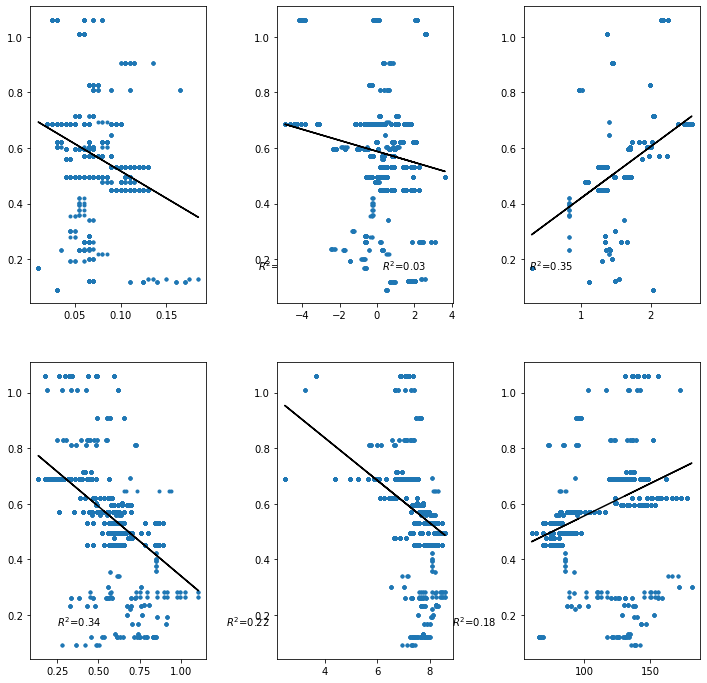

In [53]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.4)
plt.subplot(231)
plt.plot(tmp['beach_slope'],tmp['d50'],'.')

coef = np.polyfit(tmp['beach_slope'],tmp['d50'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['beach_slope'], poly1d_fn(tmp['beach_slope']), '-k')

r2 = np.min(np.corrcoef(tmp['d50'], tmp['beach_slope']))**2
plt.text(.25,.16,r'$R^2$='+str(r2)[:4])

plt.subplot(232)
plt.plot(tmp['trend'],tmp['d50'],'.')

coef = np.polyfit(tmp['trend'],tmp['d50'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['trend'], poly1d_fn(tmp['trend']), '-k')

r2 = np.min(np.corrcoef(tmp['d50'], tmp['trend']))**2
plt.text(.25,.16,r'$R^2$='+str(r2)[:4])

plt.subplot(233)
plt.plot(tmp['mstr'],tmp['d50'],'.')

coef = np.polyfit(tmp['mstr'],tmp['d50'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['mstr'], poly1d_fn(tmp['mstr']), '-k')

r2 = np.min(np.corrcoef(tmp['d50'], tmp['mstr']))**2
plt.text(.25,.16,r'$R^2$='+str(r2)[:4])


plt.subplot(234)
plt.plot(tmp['hs_mean'],tmp['d50'],'.')

coef = np.polyfit(tmp['hs_mean'],tmp['d50'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['hs_mean'], poly1d_fn(tmp['hs_mean']), '-k')

r2 = np.min(np.corrcoef(tmp['d50'], tmp['hs_mean']))**2
plt.text(.25,.16,r'$R^2$='+str(r2)[:4])

plt.subplot(235)
plt.plot(tmp['tp'],tmp['d50'],'.')

coef = np.polyfit(tmp['tp'],tmp['d50'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['tp'], poly1d_fn(tmp['tp']), '-k')

r2 = np.min(np.corrcoef(tmp['d50'], tmp['tp']))**2
plt.text(.25,.16,r'$R^2$='+str(r2)[:4])

plt.subplot(236)
plt.plot(tmp['dir'],tmp['d50'],'.')

coef = np.polyfit(tmp['dir'],tmp['d50'],1)
poly1d_fn = np.poly1d(coef) 
plt.plot(tmp['dir'], poly1d_fn(tmp['dir']), '-k')

r2 = np.min(np.corrcoef(tmp['d50'], tmp['dir']))**2
plt.text(.25,.16,r'$R^2$='+str(r2)[:4])

In [54]:
# tmp.keys()

In [55]:
join_dist

0.0015

In [56]:
ind = np.where(tmp['distance']<join_dist)[0]
tmp = tmp.iloc[ind]
len(tmp)

5104

In [57]:
tmp['latitude']=np.mean(tmp['latitude_right'],axis=1)
tmp['longitude']=np.mean(tmp['longitude_right'],axis=1)
tmp=tmp.drop(columns=['latitude_right','longitude_right'])

In [58]:
# tmp['latitude']=np.mean(tmp['latitude_right'],axis=1)
# tmp['longitude']=np.mean(tmp['longitude_right'],axis=1)
# tmp=tmp.drop(columns=['latitude_right','longitude_right'])

In [59]:
tmp.keys()

Index(['hs_max', 'hs_mean', 'dir', 'tp', 'latitude_left', 'latitude_left',
       'longitude_left', 'longitude_left', 'quality_flag_left',
       'quality_flag_right', 'd50', 'width_ci_average', 'beach_slope_average',
       'beach_slope_median', 'sl_points_average', 'mstr', 'prc_mstr_obs',
       'min_tide_obs', 'max_tide_obs', 'site_id', 'beach_slope',
       'lower_conf_bound', 'upper_conf_bound', 'width_ci', 'sl_points',
       'trend', 'distance', 'latitude', 'longitude'],
      dtype='object')

In [60]:
# # try:
# map = folium.Map(
#                 location=[np.mean(tmp['latitude']), np.mean(tmp['longitude'])], 
#                 zoom_start=4, 
#                 control_scale=True,
#                 tiles='stamentoner',#tiles="Stamen Terrain", 
# )

# for counter, (lat,lon) in enumerate(zip(tmp['latitude'],tmp['longitude'])):
#     folium.CircleMarker(location=[lat, lon],
#                                 radius = 3,
#                                 fill=True, # Set fill to True
#                                 color = 'magenta',
#                                 opacity=0.1,
#                                 fill_opacity=0.7).add_to(map)
    
# map

In [385]:
tmp.to_csv('model_data_out/ML_slope_wave_atlantic_2022-05-18_'+dataset+'_'+str(join_dist)+'_'+merge+'_'+choice+'.csv')